In [2]:
import numpy as np
import pandas as pd
import math
import ptitprince as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
sns.set_style("white")
sns.set_context("paper", font_scale=1.5)


import scipy.stats as stats

C:\GBW_MyPrograms\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Baseline vs follow-up

### load movement quality data

In [3]:
raw_t0 = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/MovQual/Output/MoveQual_aff.xlsx', sheet_name = 'T0')
raw_t1 = pd.read_excel('C:/Users/u0117545/Documents/GitHub/ULIFT_BC/MovQual/Output/MoveQual_aff.xlsx', sheet_name = 'T1')
print('No. of baseline: {}, No. of follow-up: {}'.format(len(raw_t0), len(raw_t1)))

No. of baseline: 46, No. of follow-up: 45


In [4]:
# find participants that have T0 and T1 data 
pp_t0 = raw_t0.iloc[:, 0:3].drop('trial', axis = 1)
pp_t1 = raw_t1.iloc[:, 0:3].drop('trial', axis = 1)

# remove pp 18 and 34 --> data incomplete 
pp_t1 = pp_t1.drop(pp_t1.index[pp_t1['ppID'] == 'BC_018'])
pp_t1 = pp_t1.drop(pp_t1.index[pp_t1['ppID'] == 'BC_034'])

# merge list and only retain where both data sets are complete
pp_list = pd.merge(pp_t0, pp_t1, on='ppID')
pp_list = pp_list.drop(['time_x', 'time_y'], axis = 1)


print('no. of participants with baseline and follow-up measures: {}'.format(len(pp_list)))
print(pp_list)

no. of participants with baseline and follow-up measures: 34
      ppID
0   BC_011
1   BC_012
2   BC_013
3   BC_014
4   BC_015
5   BC_016
6   BC_017
7   BC_019
8   BC_020
9   BC_023
10  BC_026
11  BC_029
12  BC_031
13  BC_032
14  BC_033
15  BC_035
16  BC_036
17  BC_037
18  BC_039
19  BC_041
20  BC_042
21  BC_043
22  BC_044
23  BC_045
24  BC_046
25  BC_047
26  BC_048
27  BC_049
28  BC_050
29  BC_051
30  BC_054
31  BC_055
32  BC_058
33  BC_059


In [5]:
# only retain the participants with both T0 and T1 data
raw_t0 = pd.merge(raw_t0, pp_list, on='ppID')
raw_res_t0 = raw_t0[['ppID', 'time','lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res' , 'rms_res']]


raw_t1 = pd.merge(raw_t1, pp_list, on='ppID')
raw_res_t1 = raw_t1[['ppID', 'time','lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res' , 'rms_res']]


assert len(raw_t0) == len(raw_t1)

raw = pd.concat([raw_t0, raw_t1], axis=0, ignore_index=True)

# only retain the vector data
raw_res = raw[[ 'time','lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res' , 'rms_res']]
raw_res.head()

,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,T0,4.932879,0.951037,-6.483206,0.615961,4.861625
1,T0,3.473117,1.023576,-7.067763,0.480627,5.040381
2,T0,2.997241,1.210363,-8.265346,0.232062,2.915511
3,T0,2.741568,0.819376,-6.369987,0.653517,5.698095
4,T0,0.674435,1.110880,-6.628168,0.454826,3.852422


### load questionnaire data

In [6]:
raw_questionnaire = pd.read_csv("UPLIFTBC-QuickDASH_DATA_2023-01-05_1222.csv", delimiter='\t')
#QuickDASH data
raw_dash = raw_questionnaire.drop('pain_score', axis =1)
# VAS data
raw_vas = raw_questionnaire[['record_id', 'redcap_event_name', 'pain_score']]

In [7]:
raw_res_t0.head()

,ppID,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,BC_011,T0,4.932879,0.951037,-6.483206,0.615961,4.861625
1,BC_012,T0,3.473117,1.023576,-7.067763,0.480627,5.040381
2,BC_013,T0,2.997241,1.210363,-8.265346,0.232062,2.915511
3,BC_014,T0,2.741568,0.819376,-6.369987,0.653517,5.698095
4,BC_015,T0,0.674435,1.110880,-6.628168,0.454826,3.852422


In [8]:
# baseline QuickDASH 
idx = raw_dash['redcap_event_name'].str.contains('t0')
mask = np.where(idx)[0]
baseline_dash = raw_dash.iloc[mask]
baseline_dash.head()

,record_id,redcap_event_name,quickdash_1,quickdash_2,quickdash_3,quickdash_4,quickdash_5,quickdash_6,quickdash_7,quickdash_8,quickdash_9,quickdash_10,quickdash_11
0,BC_001,t0_baseline_presur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,BC_002,t0_baseline_presur_arm_1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,BC_003,t0_baseline_presur_arm_1,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0
10,BC_004,t0_baseline_presur_arm_1,4.0,3.0,1.0,3.0,1.0,2.0,1.0,3.0,1.0,1.0,1.0
11,BC_005,t0_baseline_presur_arm_1,3.0,2.0,2.0,1.0,1.0,2.0,2.0,2.0,3.0,3.0,3.0


#### QuickDASH analysis

In [9]:
# remove participants with more than 2 NaNs
print("Before removing rows with missing data: {} rows".format(len(baseline_dash)))
df_dash = baseline_dash.dropna(thresh=baseline_dash.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))

#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)

# find the people with a dash score higher than 15
idx = df_totaldash['total_score'] < 15
mask = np.where(idx)[0]
prePain = df_totaldash.iloc[mask]
prePain = prePain.drop('total_score', axis =1)

Before removing rows with missing data: 64 rows
After removing rows with missing data: 60 rows
Average score over all participants and timepoints = 7.5795454545454515
Maximum and minumum scores are 56.81818181818182 & 0.0 respectively


In [10]:
# select the participants with baseline and follow-up measures with no disability at baseline
pp_list_noPain = pd.merge(prePain, pp_list, on='ppID')
print('No. of people with baseline & follow up measures & without baseline perceived disability: {}'.format(len(pp_list_noPain)))
print(pp_list_noPain)

No. of people with baseline & follow up measures & without baseline perceived disability: 30
      ppID
0   BC_011
1   BC_013
2   BC_014
3   BC_015
4   BC_016
5   BC_017
6   BC_019
7   BC_023
8   BC_026
9   BC_029
10  BC_031
11  BC_032
12  BC_033
13  BC_035
14  BC_036
15  BC_037
16  BC_039
17  BC_041
18  BC_042
19  BC_044
20  BC_045
21  BC_046
22  BC_047
23  BC_048
24  BC_050
25  BC_051
26  BC_054
27  BC_055
28  BC_058
29  BC_059


In [11]:
t0_noPain = pd.merge(raw_res_t0, pp_list_noPain, on='ppID')
t1_noPain = pd.merge(raw_res_t1, pp_list_noPain, on='ppID')

assert len(t0_noPain) == len(t1_noPain) == len(pp_list_noPain)

df_noPain = pd.concat([t0_noPain, t1_noPain], axis=0, ignore_index=True)
df_noPain.head()

,ppID,time,lyapExp_res,sampen_res,LDLJ_A,reg_res,rms_res
0,BC_011,T0,4.932879,0.951037,-6.483206,0.615961,4.861625
1,BC_013,T0,2.997241,1.210363,-8.265346,0.232062,2.915511
2,BC_014,T0,2.741568,0.819376,-6.369987,0.653517,5.698095
3,BC_015,T0,0.674435,1.110880,-6.628168,0.454826,3.852422
4,BC_016,T0,2.743834,1.010746,-6.985151,0.694873,4.771970


In [12]:
t0_dash = pd.merge(df_totaldash, pp_list_noPain, on='ppID')
print('average total dash score at t0: {}'.format(round(t0_dash['total_score'].mean(),2)))
print('standarddeviation total dash score at t0: {}'.format(round(t0_dash['total_score'].std(),2))) 


average total dash score at t0: 3.35
standarddeviation total dash score at t0: 4.36


In [13]:
# store that data for follow up analysis
%store t1_noPain

Stored 't1_noPain' (DataFrame)


#### chack gausian distribution 

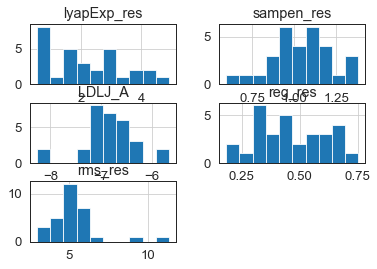

In [14]:
t0_noPain.hist()
plt.show()

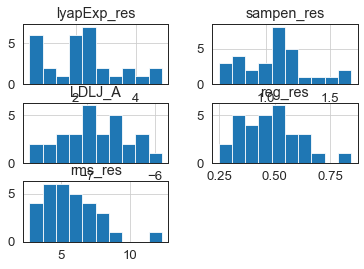

In [15]:
t1_noPain.hist()
plt.show()

Visual inspection showed no normal distribution for most of our data. 
Thus, Non-parametric testing

## Wilcoxon signed rank test to test for group differences baseline vs follow-up

In [16]:
for var in df_noPain.columns:
    if var == 'ppID' or var == 'time':
        print(80* "_" + "\n" )
        
    else:
        print('Analysing {}'.format(var))
        t_statistic, pvalue = stats.wilcoxon(t0_noPain[var], t1_noPain[var])
        print(round(t_statistic, ndigits=4), round(pvalue, ndigits=4))
        print(80* '_' + '\n')
        

________________________________________________________________________________

________________________________________________________________________________

Analysing lyapExp_res
224.0 0.8612
________________________________________________________________________________

Analysing sampen_res
197.0 0.4653
________________________________________________________________________________

Analysing LDLJ_A
220.0 0.7971
________________________________________________________________________________

Analysing reg_res
206.0 0.5857
________________________________________________________________________________

Analysing rms_res
187.0 0.3493
________________________________________________________________________________



#### Raincloud plot

In [17]:
df_noPain.columns

Index(['ppID', 'time', 'lyapExp_res', 'sampen_res', 'LDLJ_A', 'reg_res',
       'rms_res'],
      dtype='object')

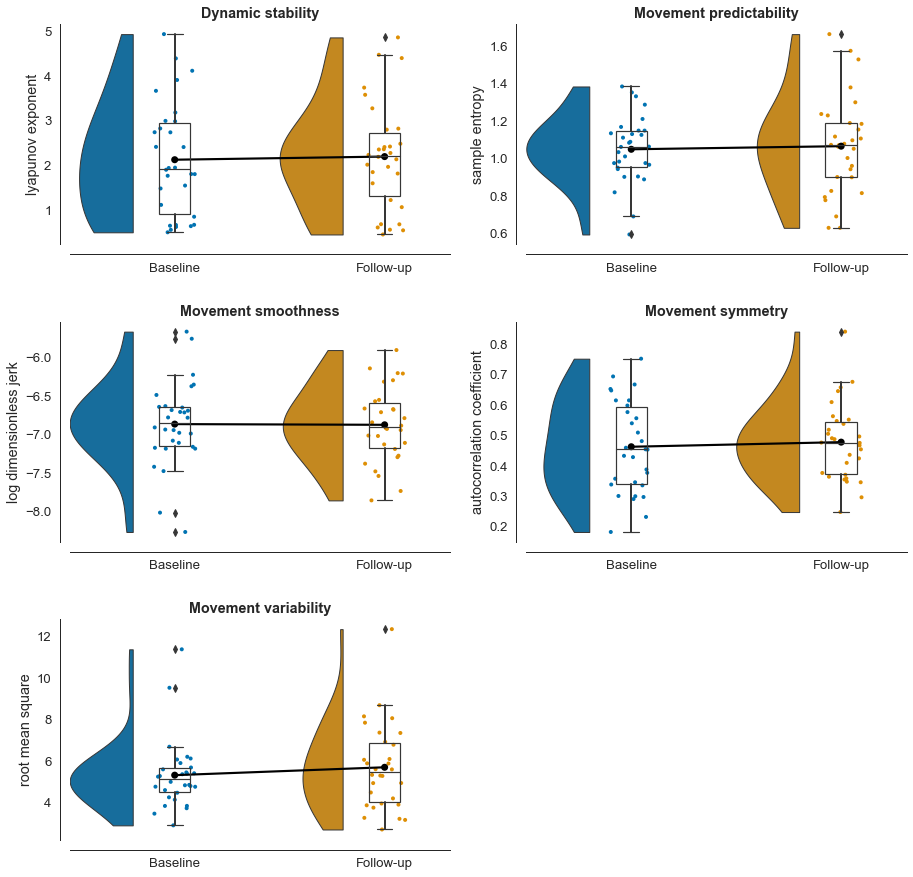

In [18]:
X = df_noPain.drop(['ppID', 'time'], axis=1)
# find minimum required rows given 2 columns
ncols = 2
nrows = math.trunc(len(X.columns) / ncols + (len(X.columns) % ncols > 0))

dx = 'time'; ort = 'v'; pal = 'colorblind'; sigma = 0.6; viol = 0.6; mv = .0; point=4

f = plt.figure(figsize = (15,15))
plt.subplots_adjust(hspace=0.35)
#plt.suptitle('Movement quality before and after surgery', weight = 'bold')
f.tight_layout()


for n, columns in enumerate(X.columns):
    #add a new subplot itteratively
    ax = plt.subplot(nrows, ncols, n+1)
    
    pt.RainCloud(x=dx, y=columns, data=df_noPain, ax=ax, orient = ort,
                palette = pal, bw=sigma, width_viol = viol, move = mv, point_size=point, pointplot=True, 
                 linecolor='black')
    sns.despine(offset=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    f.canvas.draw()

    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Baseline'
    labels[1] = 'Follow-up'
    ax.set_xticklabels(labels)
  
    if n==0:
        ax.set_ylabel('lyapunov exponent')
        ax.set_title('Dynamic stability', weight='bold')
    elif n==1:
        ax.set_ylabel('sample entropy')
        ax.set_title('Movement predictability', weight = 'bold')
    elif n==2:
        ax.set_ylabel('log dimensionless jerk')  
        ax.set_title('Movement smoothness', weight = 'bold')
    elif n==3:
        ax.set_ylabel('autocorrelation coefficient')
        ax.set_title('Movement symmetry', weight='bold')
    elif n==4:
        ax.set_ylabel('root mean square')
        ax.set_title('Movement variability', weight='bold')
        
plt.savefig('C:\\Users\\u0117545\\OneDrive - KU Leuven\\1.Abstract & Papers\\6.0.ULFunctioning\\MovQual\\MovementQuality_res.tiff')

There are no significant differences between baseline and follow-up movement quality 

In [32]:
baseline_pain = df_dash.rename(columns={'record_id' : 'ppID'})
df_dash.head()
baseline_pain = pd.merge(baseline_pain, pp_list_noPain)


print('average pain severity at t0: {}'.format(round(baseline_pain['quickdash_9'].mean(),2)))
print('standarddeviation pain severity at t0: {}'.format(round(baseline_pain['quickdash_9'].std(),2)))

average pain severity at t0: 1.1
standarddeviation pain severity at t0: 0.31


# Follow-up people with preceived diability vs no perceived disability

### calculate dash scores at follow-up measurement

In [112]:
raw_dash

# follow-up QuickDASH 
idx = raw_dash['redcap_event_name'].str.contains('t1')
mask = np.where(idx)[0]
follow_raw = raw_dash.iloc[mask]

In [113]:
# total DASH scores 
# remove participants with more than 2 NaNs
# Remove rows with missing values
print("Before removing rows with missing data: {} rows".format(len(follow_raw)))
df_dash = follow_raw.dropna(thresh=follow_raw.shape[1]-1, axis=0)
print("After removing rows with missing data: {} rows".format(len(df_dash)))

som = df_dash.iloc[:,2:].sum(axis='columns')
col_n_counts = np.sum(df_dash.applymap(lambda x: 0 if pd.isnull(x) else 1), axis=1)-2
complete = col_n_counts.apply(lambda x:  x >= 10 )

total_score = ((som/col_n_counts)-1) * 25

print('Average score over all participants and timepoints = {}'.format(np.mean(total_score)))
print('Maximum and minumum scores are {} & {} respectively'.format(total_score.max(), total_score.min()))

#set-up dataframe for total dash scores. 
d = {'ppID': df_dash['record_id'],
    'total_score': total_score}
df_totaldash = pd.DataFrame(data=d)

Before removing rows with missing data: 52 rows
After removing rows with missing data: 44 rows
Average score over all participants and timepoints = 21.239669421487605
Maximum and minumum scores are 70.45454545454545 & 0.0 respectively


In [114]:
# combine the dash scores with the movement quality data 
t1_noPain = t1_noPain.drop('time', axis = 1)
df_temp = df_totaldash.merge(t1_noPain)

### split the group on perceived disability and no perceived disability

In [115]:
# find the people with a dash score higher than 15
idx = df_temp['total_score'] >= 15
mask = np.where(idx)[0]
disabled = df_temp.iloc[mask]
disabled.insert(loc=len(disabled.columns),
          column='Group',
          value=0)


# find the people with a dash score lower than 15
idx = df_temp['total_score'] < 15
mask = np.where(idx)[0]
not_disabled = df_temp.iloc[mask]
not_disabled.insert(loc=len(not_disabled.columns),
                   column = 'Group',
                   value = 1)

print('number of people with perceived disablity: {}'.format(len(disabled)))
print('number of people with no perceived disablity: {}'.format(len(not_disabled)))

df_follow = pd.concat([disabled, not_disabled], axis =0, ignore_index = True )

number of people with perceived disablity: 11
number of people with no perceived disablity: 14


for var in df_follow.columns:
    if var =='ppID' or var == 'Group':
        print(80 * '_' + '\n')
    else:
        print('Analyzing {}'.format(var))
        tstatistic, pvalue = stats.mannwhitneyu(disabled[var], not_disabled[var])
        print(round(tstatistic, 4), round(pvalue, 4))
            
        print(80 * '_' + '\n')
        

X_follow = df_follow.drop(['ppID', 'total_score', 'Group'], axis=1)
ncols = 2
nrows = len(X_follow.columns) // ncols + (len(X_follow.columns) % ncols > 0)

dx = 'Group'; ort = 'v'; pal = 'colorblind'; sigma = 0.4; viol = 0.6; mv = .0; point=4

f = plt.figure(figsize = (15,15))
plt.subplots_adjust(hspace=0.35)

f.tight_layout()

for n, columns in enumerate(X_follow.columns):
    ax = plt.subplot(nrows, ncols, n+1)    
    pt.RainCloud(x=dx, y=columns, data = df_follow, ax=ax, orient = ort,
                palette = pal, bw=sigma, width_viol = viol, move = mv, point_size=point, pointplot=True, 
                 linecolor='black')
    
    sns.despine(offset=10)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    f.canvas.draw()
    labels = [item.get_text() for item in ax.get_xticklabels()]
    labels[0] = 'Perceived disability'
    labels[1] = 'No perceived disability'
    
    ax.set_xticklabels(labels)
    
    if n==0:
        ax.set_ylabel('lyapunov exponent')
        ax.set_title('Dynamic stability', weight='bold')
    elif n==1:
        ax.set_ylabel('sample entropy')
        ax.set_title('Movement predictability', weight = 'bold')
    elif n==2:
        ax.set_ylabel('log dimensionless jerk')  
        ax.set_title('Movement smoothness', weight = 'bold')
    elif n==3:
        ax.set_ylabel('autocorrelation coefficient')
        ax.set_title('Movement symmetry', weight='bold')
    elif n==4:
        ax.set_ylabel('root mean square')
        ax.set_title('Movement variability', weight='bold')
        
    
plt.savefig('C:\\Users\\u0117545\\OneDrive - KU Leuven\\1.Abstract & Papers\\6.0.ULFunctioning\\MovQual\\MovementQuality_Follow.tiff')    

# Relate post-op movement quality with Quick Dash scores and pain scores

In [116]:
# sort values on ppID
df_follow = df_follow.sort_values('ppID', axis = 0, ignore_index=True)

In [117]:
# Follow up VAS 
idx = raw_vas['redcap_event_name'].str.contains('t1')
mask = np.where(idx)[0]
follow_vas = raw_vas.iloc[mask]

follow_vas = follow_vas.rename(columns={"record_id": "ppID"})
follow_vas.head()

,ppID,redcap_event_name,pain_score
1,BC_001,t1_1_month_postsur_arm_1,0.0
5,BC_002,t1_1_month_postsur_arm_1,1.0
8,BC_003,t1_1_month_postsur_arm_1,4.0
12,BC_005,t1_1_month_postsur_arm_1,5.0
15,BC_006,t1_1_month_postsur_arm_1,0.0


In [118]:
follow_vas = pd.merge(df_follow, follow_vas)
# remove nans

follow_vas = follow_vas.loc[~follow_vas['pain_score'].isna()]

## Correlations between Quick DASH and movement quality

In [119]:
for var in df_follow.columns:
    if var == 'ppID' or var == 'Group':
        print(80*'_'+'\n')
        
    else:
        corr, pvalue = stats.spearmanr(follow_vas['total_score'], follow_vas[var])
        print('Analysing: {}'.format(var))
        print('corr = {} and pvalue = {}'. format(round(corr, 4), round(pvalue, 4)))
        print(80*'_'+ '\n')

________________________________________________________________________________

Analysing: total_score
corr = 1.0 and pvalue = 0.0
________________________________________________________________________________

Analysing: lyapExp_res
corr = 0.2581 and pvalue = 0.2344
________________________________________________________________________________

Analysing: sampen_res
corr = 0.0238 and pvalue = 0.9142
________________________________________________________________________________

Analysing: LDLJ_A
corr = 0.3195 and pvalue = 0.1372
________________________________________________________________________________

Analysing: reg_res
corr = 0.1476 and pvalue = 0.5014
________________________________________________________________________________

Analysing: rms_res
corr = 0.2041 and pvalue = 0.3502
________________________________________________________________________________

________________________________________________________________________________



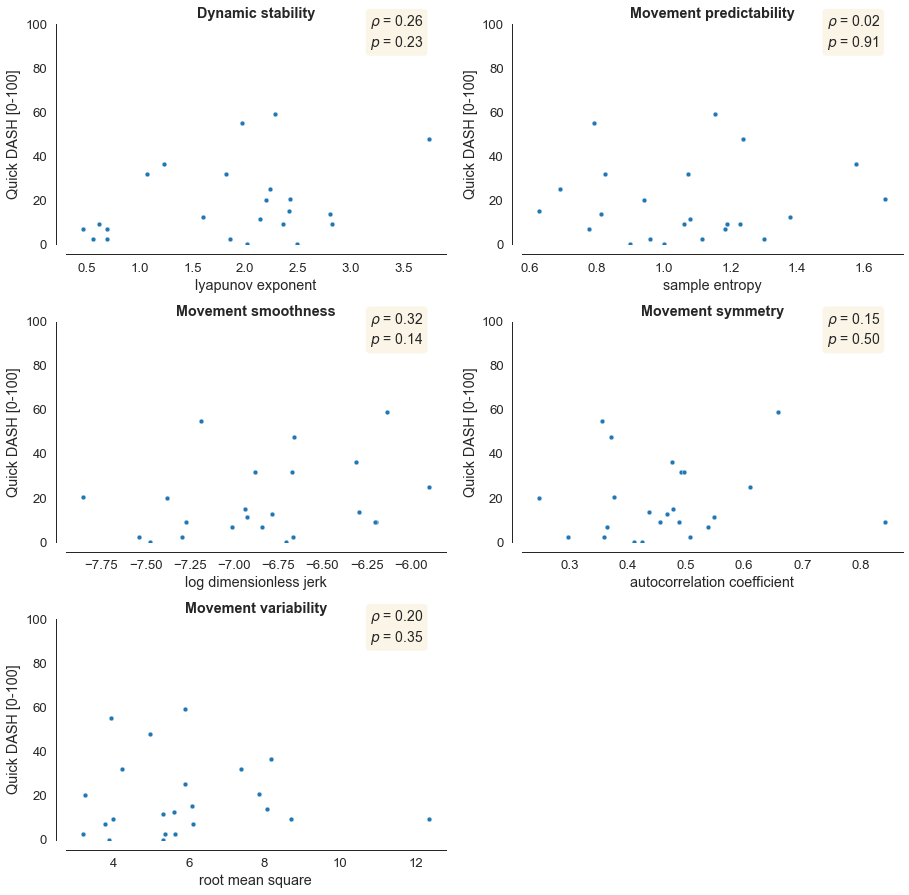

In [120]:
X_follow = follow_vas.drop(['ppID', 'Group', 'total_score', 'redcap_event_name', 'pain_score'], axis=1)
ncols = 2
nrows = len(X_follow.columns) // ncols + (len(X_follow.columns) % ncols > 0)
f = plt.figure(figsize = (15,15))
plt.subplots_adjust(hspace=0.35)
#plt.suptitle('Correlation between DASH and Movement quality', weight='bold')
f.tight_layout()

for n, columns in enumerate(X_follow.columns):
    #estimate regression line
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(follow_vas[columns], follow_vas['total_score'])
    coefs = [slope, intercept]
    fitted_curve = np.poly1d(coefs)(follow_vas[columns])
    
    corr, pvalue = stats.spearmanr(follow_vas[columns], follow_vas['total_score'])
    r_sqrt = pow(r_value, 2)
    
    textstr = '\n'.join((
        r"$\rho$ = %.2f" % (corr, ),
        '$p$ = %.2f' % (pvalue, )))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    

    # plot the results
    ax = plt.subplot(nrows, ncols, n+1)       
    sns.scatterplot(x=follow_vas[columns], y=follow_vas['total_score'])
    #sns.lineplot(x=follow_vas[columns], y=fitted_curve, color='wheat')
    #plt.plot (np.unique(follow_vas[columns]), np.poly1d(np.polyfit(follow_vas[columns], follow_vas['total_score'], 2))(np.unique(follow_vas[columns])), color = 'green')  
   
    ax.text(0.8, 1.05, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    sns.despine(offset=10)
    ax.set_ylabel('Quick DASH [0-100]')
    ax.set_ylim([0, 100])
    
    if n==0:
        ax.set_xlabel('lyapunov exponent')
        ax.set_title('Dynamic stability', weight='bold')
    elif n==1:
        ax.set_xlabel('sample entropy')
        ax.set_title('Movement predictability', weight = 'bold')
    elif n==2:
        ax.set_xlabel('log dimensionless jerk')  
        ax.set_title('Movement smoothness', weight = 'bold')
    elif n==3:
        ax.set_xlabel('autocorrelation coefficient')
        ax.set_title('Movement symmetry', weight='bold')
    elif n==4:
        ax.set_xlabel('root mean square')
        ax.set_title('Movement variability', weight='bold')
        
        
plt.savefig('C:\\Users\\u0117545\\OneDrive - KU Leuven\\1.Abstract & Papers\\6.0.ULFunctioning\\MovQual\\MovementQuality_CorrDash.tiff')    

## DASH pain and movement quality

In [121]:
pain_dash = df_dash[['record_id', 'quickdash_9']]
pain_dash = pain_dash.rename(columns={"record_id": "ppID"})


follow_vas = pd.merge(follow_vas, pain_dash)

In [122]:
for var in df_follow.columns:
    if var == 'ppID' or var == 'Group':
        print(80*'_'+'\n')
        
    else:
        corr, pvalue = stats.spearmanr(follow_vas['quickdash_9'], follow_vas[var])
        print('Analysing: {}'.format(var))
        print('corr = {} and pvalue = {}'. format(round(corr, 4), round(pvalue, 4)))
        print(80*'_'+ '\n')

________________________________________________________________________________

Analysing: total_score
corr = 0.6929 and pvalue = 0.0002
________________________________________________________________________________

Analysing: lyapExp_res
corr = 0.1486 and pvalue = 0.4986
________________________________________________________________________________

Analysing: sampen_res
corr = 0.1229 and pvalue = 0.5765
________________________________________________________________________________

Analysing: LDLJ_A
corr = 0.4537 and pvalue = 0.0297
________________________________________________________________________________

Analysing: reg_res
corr = 0.2279 and pvalue = 0.2957
________________________________________________________________________________

Analysing: rms_res
corr = 0.1297 and pvalue = 0.5553
________________________________________________________________________________

________________________________________________________________________________



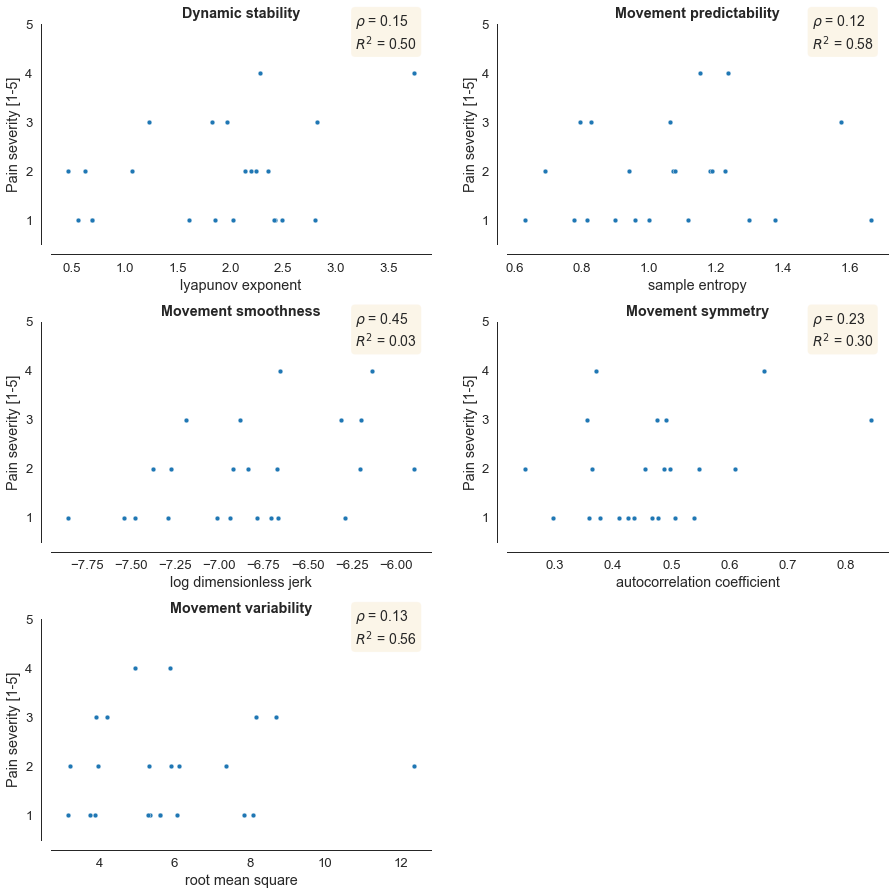

In [131]:
X_follow = follow_vas.drop(['ppID', 'Group', 'total_score', 'redcap_event_name', 'pain_score', 'quickdash_9'], axis=1)
ncols = 2
nrows = len(X_follow.columns) // ncols + (len(X_follow.columns) % ncols > 0)
f = plt.figure(figsize = (15,15))
plt.subplots_adjust(hspace=0.35)
#plt.suptitle('Correlation between DASH Pain and Movement quality', weight='bold')
f.tight_layout()

for n, columns in enumerate(X_follow.columns):
    #estimate regression line
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(follow_vas[columns], follow_vas['quickdash_9'])
    coefs = [slope, intercept]
    fitted_curve = np.poly1d(coefs)(follow_vas[columns])
    
    #corr, pvalue = stats.spearmanr(follow_vas[columns], follow_vas['quickdash_9'])
    
    r, pvalue = stats.spearmanr(follow_vas[columns], follow_vas['quickdash_9'])
    #r_sqrt = pow(r_value, 2)
    
    textstr = '\n'.join((
        r'$\rho$ = %.2f' % (r, ),
        '$R^2$ = %.2f' % (pvalue, )))
    
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.3)
    

    # plot the results
    ax = plt.subplot(nrows, ncols, n+1)       
    sns.scatterplot(x=follow_vas[columns], y=follow_vas['quickdash_9'])
    #sns.lineplot(x=follow_vas[columns], y=fitted_curve, color='wheat')

   
    ax.text(0.8, 1.05, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    
    sns.despine(offset=10)
    ax.set_ylabel('Pain severity [1-5]')
    ax.set_ylim(0.5,5)
    
    if n==0:
        ax.set_xlabel('lyapunov exponent')
        ax.set_title('Dynamic stability', weight='bold')
    elif n==1:
        ax.set_xlabel('sample entropy')
        ax.set_title('Movement predictability', weight = 'bold')
    elif n==2:
        ax.set_xlabel('log dimensionless jerk')  
        ax.set_title('Movement smoothness', weight = 'bold')
    elif n==3:
        ax.set_xlabel('autocorrelation coefficient')
        ax.set_title('Movement symmetry', weight='bold')
    elif n==4:
        ax.set_xlabel('root mean square')
        ax.set_title('Movement variability', weight='bold')
        
plt.savefig('C:\\Users\\u0117545\\OneDrive - KU Leuven\\1.Abstract & Papers\\6.0.ULFunctioning\\MovQual\\MovementQuality_DashPain.tiff')    

In [124]:
print('average total dash score at t1: {}'.format(round(follow_vas['total_score'].mean(),2)))
print('standarddeviation total dash score at t1: {}'.format(round(follow_vas['total_score'].std(),2))) 

average total dash score at t1: 18.59
standarddeviation total dash score at t1: 17.44


In [125]:
print('average pain severity at t1: {}'.format(round(follow_vas['quickdash_9'].mean(),2)))
print('standarddeviation pain severity at t1: {}'.format(round(follow_vas['quickdash_9'].std(),2))) 

average total dash score at t1: 1.91
standarddeviation total dash score at t1: 1.0
